# 텐서보드

[youtube](https://www.youtube.com/watch?v=eBbEDRsCmv4)

텐서보드는 텐서플로 패키지에 포함된 디버깅 도구입니다. 텐서플로는 자체적으로 세션에 대한 여러 정보를 저장하는 기능을 제공합니다. 이러한 정보를 보통 logs 라는 디렉토리에 저장을 하는데, 이 파일을 이벤트파일이라고 합니다. 텐서보드는 이렇게 저장된 로그를 다시 읽고난 뒤 세션에 사용된 그래프와 텐서들이 어떻게 흘러가는지, 또한 미리 지정된 다양한 정보를 유용하게 시각화해주는 도구입니다.

아래에 예제는 이전에 사용한 회기법을 사용해보도록 하겠습니다.

우선 텐서보드를 사용하기 위해서는 텐서에 이름을 붙혀주는게 좋습니다. 상수나 변수, 플레이스홀더, 그 외에 텐서계산등에 'name'파라미터를 이용해 이름들을 지정해줄 수 있습니다.

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/Users/skim0119/Desktop/Project/ML_Library_Notes/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


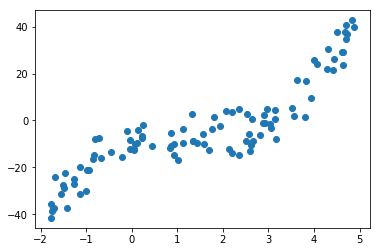

In [2]:
# 3차항식 데이터
poly = lambda x:x**3-4*x**2+6*x-9
ll, ul = -2, 5 # lower and upper limit
ndata = 100
x_data = (ul - ll) * np.random.random(ndata) + ll
x_data.sort()
y_data = poly(x_data) + np.random.normal(0,5,ndata)
plt.scatter(x_data,y_data)

## 직렬화된 데이터 저장

텐서보드는 텐서플로 이벤트파일을 읽어들여 시각화하는 도구입니다. 이벤트파일은 텐서플로 실행에 대한 다양한 정보가 들어있습니다. 텐서보드에 정보를 나타낸느 방식은 다음과 같은 순서로 진행됩니다.

첫째, 텐서플로 그래프를 생성한 뒤, 어떤 노드에서 데이터를 수집할지를 지정합니다. 이러한 지정방식은 summary operation에 해당하며, 노드에 오퍼레이션을 달아주는 방식입니다.

예를들어, 합성곱 신경망을 트레이닝한다 합시다. 우리가 기록하고싶은 내용은 시간에 따른 학습률과 그 외에 함수들의 변화입니다. 이러한 노드들은 tf.summary.scalar 오퍼레이션을 노드에 달아둠으로써 해당노드에 이벤트가 발생할때마다 상수값을 기록할 수 있습니다. 그리고 각 노드에 '학습률' 또는 'loss function'이라는 태그를 지정해둘 수 있습니다.

summary 오퍼레이션은 scalar 외에 다양한 종류가 존재합니다. 만약 레이어에서 나오는 활성함수의 분포를 알고싶다면 tf.summary.histogram 을 사용할 수도 있습니다. [tf.summary](https://www.tensorflow.org/api_docs/python/tf/summary)

텐서플로 그래프에 노드는 직접적으로 실행되었거나 실행된 다른 노드에 직접적으로 관여되있을 때 실행됩니다. 텐서보드 이벤트를 기록할 때 사용되는 summary 노드들은 그래프에 직접적으로 관여되어있지 않는 노드들이고, 그렇기때문에 연결되있는 노드가 실행되더라도 summary 노드는 실행되지 않습니다. 다시말해 summary 노드는 다른 노드들을 계산할때 전혀 관여하지 않는다는 이야기입니다. 그렇기때문에, 모든 summary 노드들을 모아서 따로 실행시켜주어야 합니다. 방법은 다음과 같습니다.

```py
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter('./logs', sess.graph)
...
summary = sess.run(merged, ... )
writer.add_summary(summary, ... )
```

위와 같이 tf.summary.merge_all()을 사용해 merge라는 통합 기록 오퍼레이션을 만든 뒤, merge를 실행해 기록할 내용을 얻어냅니다. 여기서 merge는 각각의 summary 오퍼레이션의 집합체입니다. 이를 실행해 얻어낸 summary는 그래프에서 summary 노드들에서 얻어낸 데이터의 종합 기록입니다. 이를 FileWriter을 사용해 외부 파일에 기록합니다.

FileWriter의 생성자에 그래프를 넣어줄 경우, 텐서보드 안에서 텐서의 모양과 함께 그래프를 시각화해줍니다.

summary 안에는 언제 어떤 데이터를 얻었는지를 말해주는 global_step을 함께 넣어주기도 합니다. 수많은 트레이닝에 대해 모든 데이터를 기록하는것보다 주기적인 step 마다 한번씩 기록해주는 방식이 더 메모리를 절약할 수 있습니다.

Final Loss :  39.744263


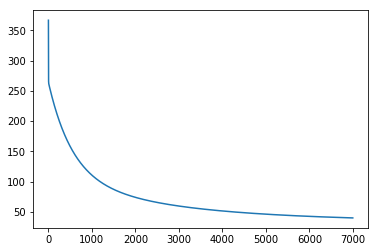

In [7]:
# 텐서플로를 이용한 회귀모델
# 모델 : w0 + w1x + w2x^2 + w3x^3 = 0
tf.reset_default_graph()

x_train = np.vstack([x_data**3, x_data**2, x_data, np.ones(x_data.shape)]).T
y_train = np.reshape(y_data, (ndata,1))

X = tf.placeholder(tf.float32, shape=(None, 4))
Y = tf.placeholder(tf.float32, shape=(None, 1))

global_step = tf.Variable(0, trainable=False, name='global_step')

with tf.name_scope('layer'):
    w = tf.Variable(tf.random_uniform([4,1], -1.0, 1.0), name='weight')

with tf.name_scope('output'):
    result = tf.matmul(X,w,name='result')

with tf.name_scope('optimizer'):
    Loss = tf.reduce_mean(tf.square(result-Y))
    Optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-4).minimize(Loss, global_step=global_step)
    tf.summary.scalar('loss', Loss)

# 세션
sess = tf.Session()
saver = tf.train.Saver(tf.global_variables())

ckpt = tf.train.get_checkpoint_state('./model')
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    saver.restore(sess, ckpt.model_checkpoint_path)
else:
    sess.run(tf.global_variables_initializer())
    
# 저장
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter('./logs', sess.graph)
    
loss_table = []

# 최적화를 1000번 수행합니다.
for i in range(7000):
    _, loss = sess.run([Optimizer, Loss], feed_dict={X: x_train, Y: y_train})
    loss_table.append(loss)
    
    summary = sess.run(merged, feed_dict={X: x_train, Y: y_train})
    writer.add_summary(summary, global_step=sess.run(global_step))

saver.save(sess, './model/regression.ckpt', global_step=global_step)

# Loss 결과를 그래프로 출력합니다.
plt.plot(loss_table)
print('Final Loss : ', loss_table[-1])

sess.close()

```bash
tensorboard --logdir=path/to/log-directory
http://localhost:6006
```